## Setup ##

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Deep Learning on CIFAR10

Building a DNN with 20 hidden layers of 100 neurons each using He intialisation and the ELU activation function.

In [2]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [32,32,3]))

for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 activation = "elu",
                                 kernel_initializer = "he_normal"))

Let's add the softmax layers as the output layer.

In [3]:
model.add(keras.layers.Dense(10, activation = "softmax"))

Let's use a Nadam optimizer with a learning rate of 5e-5.

In [4]:
optimizer = keras.optimizers.Nadam(lr=5e-5)
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = optimizer,
              metrics = ['accuracy'])

Let's load the CIFAR10 dataset. And use first 5000 images of training set as validation set for early stopping.

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

Let's create the callbacks and use them in the training.

In [6]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("cifar10_model.h5", save_best_only = True)
run_index = 1 #In order to make sure to create different log folder for tensorboard
run_logdir = os.path.join(os.curdir, "cifar10_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [8]:
%tensorboard --logdir=./cifar10_logs --port=8080

Reusing TensorBoard on port 8080 (pid 11832), started 0:00:01 ago. (Use '!kill 11832' to kill it.)

In [9]:
model.fit(X_train, y_train, epochs = 100, 
          validation_data = (X_valid, y_valid),
         callbacks = callbacks)

Epoch 1/100
   1/1407 [..............................] - ETA: 0s - loss: 165.9659 - accuracy: 0.0625WARNING:tensorflow:From C:\Users\G Surya Krishna\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1407/1407 [==============================] - 12s 8ms/step - loss: 4.0140 - accuracy: 0.1670 - val_loss: 2.2015 - val_accuracy: 0.2172
Epoch 2/100
1407/1407 [==============================] - 12s 9ms/step - loss: 2.0935 - accuracy: 0.2375 - val_loss: 2.0857 - val_accuracy: 0.2390
Epoch 3/100
1407/1407 [==============================] - 11s 8ms/step - loss: 1.9586 - accuracy: 0.2818 - val_loss: 2.0965 - val_accuracy: 0.2520
Epoch 4/100
1407/1407 [==============================] - 11s 8ms/step - loss: 1.8704 - accuracy: 0.3200 - val_loss: 1.8752 - val_accuracy: 0.3266
Epoch 5/100
1407/1

1407/1407 [==============================] - 11s 8ms/step - loss: 1.1681 - accuracy: 0.5810 - val_loss: 1.5611 - val_accuracy: 0.4612
Epoch 53/100
1407/1407 [==============================] - 11s 8ms/step - loss: 1.1595 - accuracy: 0.5836 - val_loss: 1.5471 - val_accuracy: 0.4716
Epoch 54/100
1407/1407 [==============================] - 11s 8ms/step - loss: 1.1555 - accuracy: 0.5850 - val_loss: 1.5758 - val_accuracy: 0.4684
Epoch 55/100
1407/1407 [==============================] - 11s 8ms/step - loss: 1.1477 - accuracy: 0.5866 - val_loss: 1.5684 - val_accuracy: 0.4694
Epoch 56/100
1407/1407 [==============================] - 11s 8ms/step - loss: 1.1435 - accuracy: 0.5884 - val_loss: 1.5305 - val_accuracy: 0.4834
Epoch 57/100
1407/1407 [==============================] - 11s 8ms/step - loss: 1.1319 - accuracy: 0.5921 - val_loss: 1.5520 - val_accuracy: 0.4732
Epoch 58/100
1407/1407 [==============================] - 11s 8ms/step - loss: 1.1330 - accuracy: 0.5929 - val_loss: 1.5621 - val_a

We can see with lowest validation loss we get 47% accuracy on the validation set.It took 39(59-20) epochs to converge.

## Batch Normalisation

Let's add Batch Normalization layers after each layer except the output layers and before the input layer.

In [3]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [32,32,3]))
model.add(keras.layers.BatchNormalization())

for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer = "he_normal"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("elu"))

model.add(keras.layers.Dense(10, activation = "softmax"))

optimizer = keras.optimizers.Nadam(lr=5e-4) #Note the change in learning rate.
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = optimizer,
              metrics = ['accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience = 20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("cifar10_bn_model.h5", save_best_only = True)
run_index = 1 #In order to make sure to create different log folder for tensorboard
run_logdir = os.path.join(os.curdir, "cifar10_logs", "run_bn_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs = 100, 
          validation_data = (X_valid, y_valid),
         callbacks = callbacks)


Epoch 1/100
   1/1407 [..............................] - ETA: 0s - loss: 3.0445 - accuracy: 0.1250WARNING:tensorflow:From C:\Users\G Surya Krishna\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1407/1407 [==============================] - 15s 11ms/step - loss: 1.8413 - accuracy: 0.3410 - val_loss: 1.6651 - val_accuracy: 0.4082
Epoch 2/100
1407/1407 [==============================] - 15s 11ms/step - loss: 1.6683 - accuracy: 0.4052 - val_loss: 1.6210 - val_accuracy: 0.4146
Epoch 3/100
1407/1407 [==============================] - 15s 11ms/step - loss: 1.5970 - accuracy: 0.4328 - val_loss: 1.5325 - val_accuracy: 0.4412
Epoch 4/100
1407/1407 [==============================] - 15s 11ms/step - loss: 1.5477 - accuracy: 0.4483 - val_loss: 1.4931 - val_accuracy: 0.4660
Epoch 5/100
1407

[1.31340754032135, 0.09200000017881393]

The Model is converging faster, producing better model and Training speed is decreased.

## SELU as Activation (Self-Normalized Model)

How about replacing Batch Normalization with SELU? Let's do it by ensuring the network is self-normalized.

In [13]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [32,32,3]))

for _ in range(20):
    model.add(keras.layers.Dense(100, 
                                 activation = "selu",
                                 kernel_initializer = "lecun_normal"))

model.add(keras.layers.Dense(10, activation = "softmax"))

optimizer = keras.optimizers.Nadam(lr=7e-4) #Note the change in learning rate.
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = optimizer,
              metrics = ['accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("cifar10_selu_model.h5", save_best_only=True)
run_index = 1 
run_logdir = os.path.join(os.curdir, "cifar10_logs", "run_selu_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis = 0)
X_stds = X_train.std(axis = 0)
X_train_scaled = (X_train-X_means)/X_stds
X_valid_scaled = (X_valid-X_means)/X_stds
X_test_scaled = (X_test - X_means)/X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)


Epoch 1/100
1407/1407 [==============================] - 15s 11ms/step - loss: 1.9331 - accuracy: 0.3072 - val_loss: 1.8533 - val_accuracy: 0.3268
Epoch 2/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.7170 - accuracy: 0.3907 - val_loss: 1.8202 - val_accuracy: 0.3390
Epoch 3/100
1407/1407 [==============================] - 9s 7ms/step - loss: 1.6181 - accuracy: 0.4279 - val_loss: 1.6897 - val_accuracy: 0.3962
Epoch 4/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.5512 - accuracy: 0.4548 - val_loss: 1.6436 - val_accuracy: 0.4336
Epoch 5/100
1407/1407 [==============================] - 11s 8ms/step - loss: 1.4913 - accuracy: 0.4808 - val_loss: 1.5915 - val_accuracy: 0.4298
Epoch 6/100
1407/1407 [==============================] - 11s 8ms/step - loss: 1.4422 - accuracy: 0.4958 - val_loss: 1.5479 - val_accuracy: 0.4506
Epoch 7/100
1407/1407 [==============================] - 11s 8ms/step - loss: 1.3932 - accuracy: 0.5126 - val_loss: 1.5112 - 

We get the better accuracy than the original model, but not as good as using batch normalisation.
It takes much less epochs to converge(18 epochs) which makes it faster model that we trained yet.

## Alpha Dropout

Let's try regularizing the model with aplha dropout. Then, without retraining the model, see if MC Dropout can achieve better accuracy.

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [32,32,3]))

for _ in range(20):
    model.add(keras.layers.Dense(100, 
                                 activation = "selu",
                                 kernel_initializer = "lecun_normal"))

model.add(keras.layers.AlphaDropout(rate = 0.1))
model.add(keras.layers.Dense(10, activation = "softmax"))

optimizer = keras.optimizers.Nadam(lr=5e-4) #Note the change in learning rate.
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = optimizer,
              metrics = ['accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("cifar10_alpha_model.h5", save_best_only=True)
run_index = 1 
run_logdir = os.path.join(os.curdir, "cifar10_logs", "run_alpha_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis = 0)
X_stds = X_train.std(axis = 0)
X_train_scaled = (X_train-X_means)/X_stds
X_valid_scaled = (X_valid-X_means)/X_stds
X_test_scaled = (X_test - X_means)/X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)


Epoch 1/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.8891 - accuracy: 0.3298 - val_loss: 1.6898 - val_accuracy: 0.4044
Epoch 2/100
1407/1407 [==============================] - 9s 7ms/step - loss: 1.6603 - accuracy: 0.4161 - val_loss: 1.6790 - val_accuracy: 0.4034
Epoch 3/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.5726 - accuracy: 0.4475 - val_loss: 1.6599 - val_accuracy: 0.4176
Epoch 4/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.5062 - accuracy: 0.4709 - val_loss: 1.6294 - val_accuracy: 0.4416
Epoch 5/100
1407/1407 [==============================] - 9s 7ms/step - loss: 1.4505 - accuracy: 0.4938 - val_loss: 1.5735 - val_accuracy: 0.4616
Epoch 6/100
1407/1407 [==============================] - 9s 7ms/step - loss: 1.4053 - accuracy: 0.5122 - val_loss: 1.5561 - val_accuracy: 0.4744
Epoch 7/100
1407/1407 [==============================] - 9s 7ms/step - loss: 1.3624 - accuracy: 0.5254 - val_loss: 1.5537 - va

The Accuracy is little spoiled compared to previous model but the convergence occured in 12 epochs.

## Monte Carlo Dropout

Let's use MC Dropout. In order to use it we have to run 10 times the same model with dropout layers during inference.

In [18]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self,inputs):
        return super().call(inputs, training = True) # In order use dropout layers at the inference time.

Let's create a new model with same weights as previous model, but with **MCAlphaDropout** instead **AlphaDropout**.

In [19]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer for layer in model.layers
    
])

In [20]:
def mc_dropout_predict_probas(mc_model, X, n_samples = 10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis = 0)

def mc_dropout_predict_classes(mc_model, X, n_samples = 10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis = 1)

In [21]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = np.mean(y_pred == y_valid[:,0])
accuracy

0.5072

There is no improvement in this case. So, the best model we got is Batch Normalisatioin Model.

## 1cycle Scheduling

In [25]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [32,32,3]))

for _ in range(20):
    model.add(keras.layers.Dense(100, 
                                 activation = "selu",
                                 kernel_initializer = "lecun_normal"))

model.add(keras.layers.AlphaDropout(rate = 0.1))
model.add(keras.layers.Dense(10, activation = "softmax"))

optimizer = keras.optimizers.Nadam(lr=1e-4) #Note the change in learning rate.
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = optimizer,
              metrics = ['accuracy'])

In [29]:
K = keras.backend

#This callback is to reduce the learning rate after each iteration by the factor.
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

#This is just to find the learning rate for which the loss starts to increase,
#Which is nothing but maximum learning rate in the 1cycle scheduler.
#Note:- After runnning for one epoch, the model resettted to previous state.
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

#Plots the learning rates vs Losses inorder to see the max learning rate.
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

352/352 [==============================] - 4s 10ms/step - loss: 2615682864775168.0000 - accuracy: 0.1419


(9.999999747378752e-06,
 9.999868392944336,
 2.4138946533203125,
 3.864195857729231)

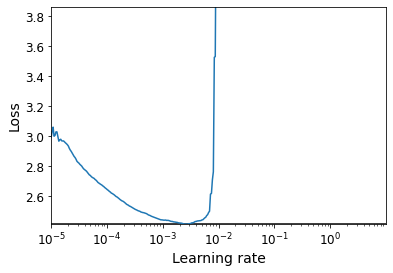

In [30]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs = 1, batch_size = batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0]+min(losses))/1.4])

From the graph, we can see at the learning rate 3e-3 the loss started diverging. 
So, this will be our maximum learning rate in onecycle scheduling.
The Default learning rate should be 2e-3. But Generally, Optimal learning rate should is 10 times less than maximum learning rate.

In [35]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [32,32,3]))

for _ in range(20):
    model.add(keras.layers.Dense(100, 
                                 activation = "selu",
                                 kernel_initializer = "lecun_normal"))

model.add(keras.layers.AlphaDropout(rate = 0.1))
model.add(keras.layers.Dense(10, activation = "softmax"))

optimizer = keras.optimizers.Nadam(lr=2e-3) #Note the change in learning rate.
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = optimizer,
              metrics = ['accuracy'])

During first half of the training, the learning rate starts to increase from $\eta_0$(max_rate/10) to $\eta_1$ (max_rate) and during second half of the training it decreases linearly from $\eta_1$ to $\eta_0$. And in few final iterations the learning rate decreases linearly by several orders of magnitude.  

In [36]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
        
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [37]:
n_epochs = 15
onecycle = OneCycleScheduler(len(X_train_scaled)//batch_size * n_epochs, max_rate = 3e-3)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/15
352/352 [==============================] - 4s 12ms/step - loss: 1.9298 - accuracy: 0.3256 - val_loss: 1.7120 - val_accuracy: 0.4064
Epoch 2/15
352/352 [==============================] - 4s 11ms/step - loss: 1.6609 - accuracy: 0.4138 - val_loss: 1.6561 - val_accuracy: 0.4224
Epoch 3/15
352/352 [==============================] - 4s 11ms/step - loss: 1.6078 - accuracy: 0.4388 - val_loss: 1.6568 - val_accuracy: 0.4226
Epoch 4/15
352/352 [==============================] - 4s 11ms/step - loss: 1.5801 - accuracy: 0.4491 - val_loss: 1.7252 - val_accuracy: 0.4196
Epoch 5/15
352/352 [==============================] - 4s 11ms/step - loss: 1.5831 - accuracy: 0.4513 - val_loss: 1.7650 - val_accuracy: 0.4264
Epoch 6/15
352/352 [==============================] - 4s 12ms/step - loss: 1.5755 - accuracy: 0.4552 - val_loss: 1.6341 - val_accuracy: 0.4340
Epoch 7/15
352/352 [==============================] - 4s 12ms/step - loss: 1.5937 - accuracy: 0.4501 - val_loss: 1.7122 - val_accuracy: 0.4136

Due to one cycle we just trained for 15 epochs but 3 times faster than the faster model we trained so far. Moreover, The Model performance imporoved drastically from 50% to 64% surpassing the previous best model performance.